# Übung 8 - Vanessa Schreck, Lisa Mattrisch

## Principal Component Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
from sklearn.decomposition import PCA
from os import listdir
from os.path import join
from itertools import combinations

%matplotlib inline

In [2]:
def covariance_matrix(X, mu):
    num_samples, _ = X.shape
    X_normalized = X - mu
    return X_normalized.T.dot(X_normalized) / num_samples 

def PCA_transform(data,k):
    '''Dimensionsreduktion mit Principal Component Analysis'''
    # Input:
    # data: Array mit Datenpunkten als Zeilen
    # k:    Anzahl zu erhaltender Dimensionen
    #
    # Output:
    # transformed_data: Array mit transformierten Daten als Zeilen
    # back_transformed: Nach der Dimensionsdimensionsreduktion in den
    #                   ursprünglichen Raum zurücktransformierte Daten
    # eigenvectors:     Eigenvektoren der Kovarianzmatrix
    # eigenvalues:      Eigenwerte der Kovarianzmatrix
    
    mu = np.mean(data, axis = 0)
    sigma = covariance_matrix(data, mu)
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    ### Eigenwerte absteigend sortieren
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = (eigenvectors.T[idx])
    ### Transformationsmatrix invertierbar machen
    while np.linalg.cond(eigenvectors) > 10**14:
        eigenvectors = eigenvectors + 0.01*np.eye(len(eigenvectors))
    ### Daten transformieren, sodass die Koordinatenachsen entlang 
    #   der Eigenvektoren der Kovarianzmatrix verlaufen
    transformed_data = (eigenvectors).dot((data - mu).T).T
    ### Dimension reduzieren
    dim_reduced = transformed_data
    dim_reduced[:, k+1:] = 0
    ### reduzierte Daten in den ursprünglichen Raum zurücktransformieren
    back_transformed = np.linalg.inv(eigenvectors).dot(dim_reduced.T).T + mu
    return transformed_data, back_transformed, eigenvectors, eigenvalues

### Aufgabe 1 - PCA und Ziffern
Daten laden:

In [3]:
train = pd.read_csv('data', delim_whitespace = True, header = None)
train_labels = np.array(train[:][0])
train_images_array = np.array(train)
train_images = train_images_array[:,1:]

In [5]:
transformed_data, _, _, _ = PCA_transform(train_images, 2)

Plot der transformierten Daten in 2 Dimensionen:

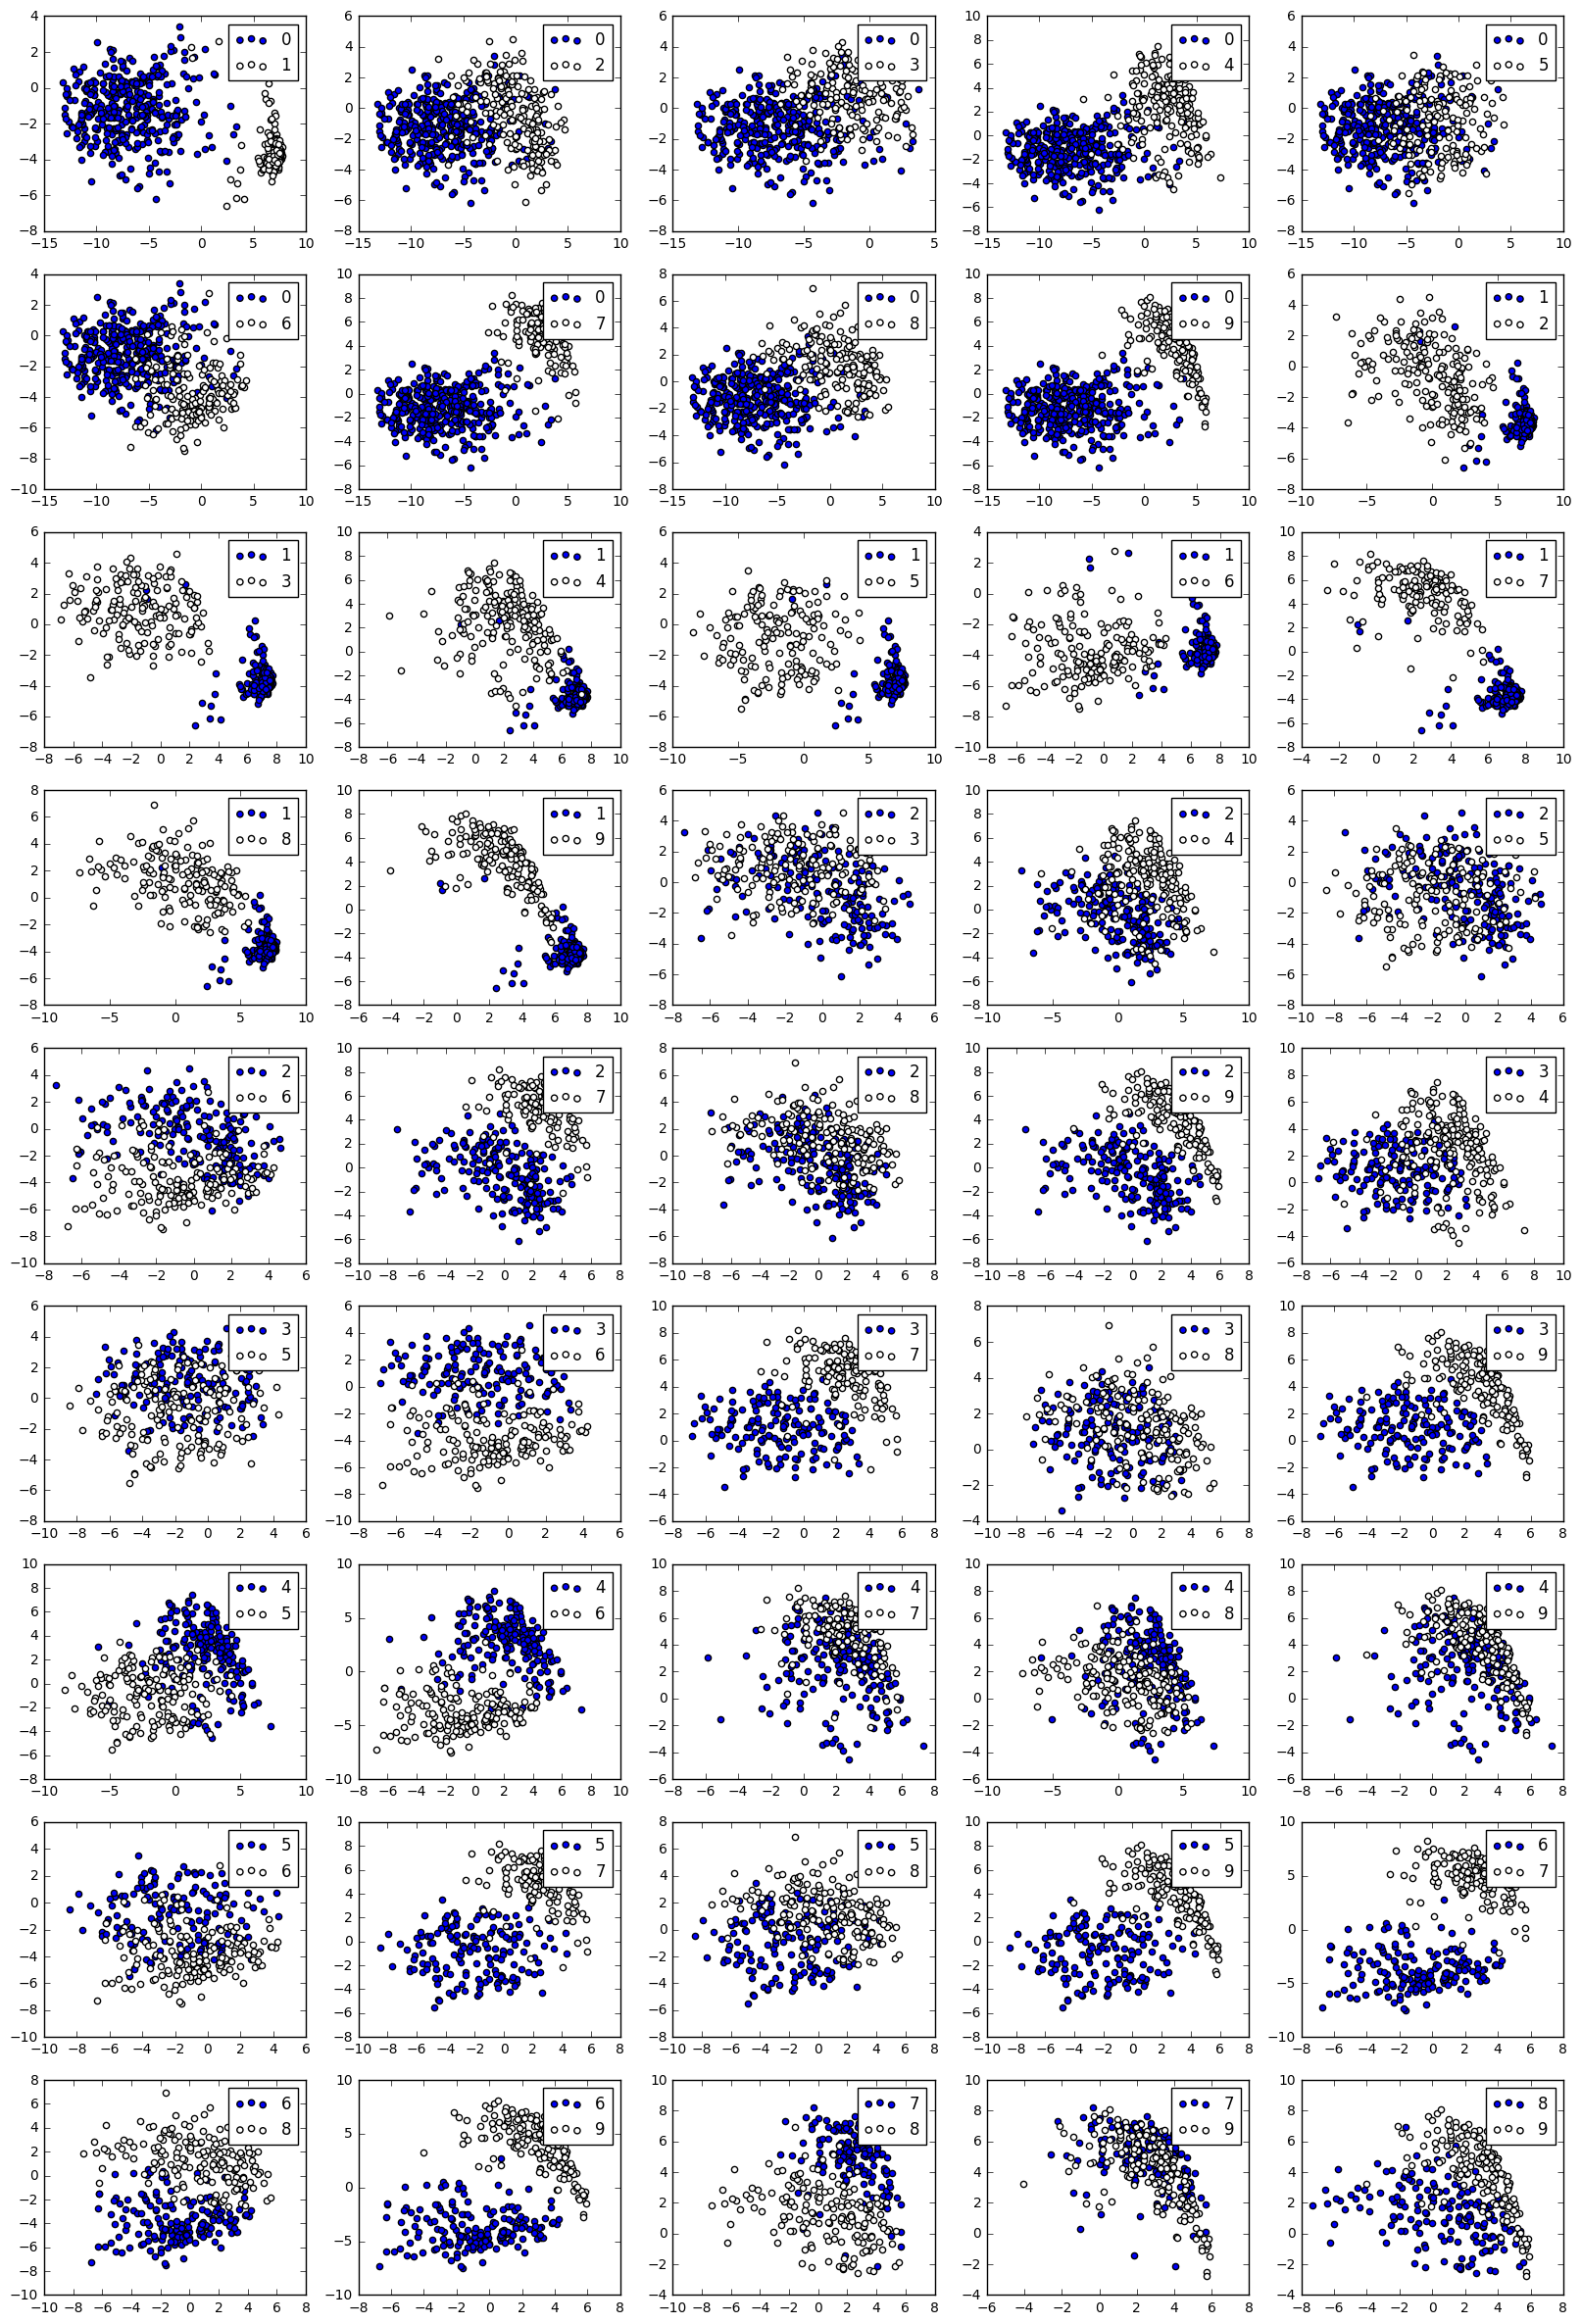

In [6]:
plt.figure(figsize=(20,30))
counter = 1
for i,j in combinations(range(10), 2):
    data1 = transformed_data[np.array(train_labels == i)]
    data2 = transformed_data[np.array(train_labels == j)]
    plt.subplot(9,5,counter)
    plt.scatter(data1[:,0], data1[:,1])
    plt.scatter(data2[:,0], data2[:,1], c = 'w')
    plt.legend((str(i), str(j)))
    counter += 1

### Aufgabe 2 - PCA und Eigenfaces

In [7]:
#Quelle: https://stackoverflow.com/questions/35723865/read-a-pgm-file-in-python
#+/- kleine Änderungen
def read_pgm(pgmf):
    """Return a raster of integers from a PGM as array."""
    assert pgmf.readline().decode('ascii') == 'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255
    raster = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    return np.array(raster)

Bilder aus den Dateien lesen und in arrays transformieren:

In [8]:
image_list = []
for face in listdir('faces'):
    f = open(join('faces', face), 'rb')
    image = np.ndarray.flatten(read_pgm(f))
    image_list.append(image)
images = np.array(image_list)

Nun führen wir eine PCA-Analyse der Daten durch:

In [9]:
transformed_data, back_transformed, eigenvectors, eigenvalues = PCA_transform(images, 6)

Um zu enscheiden, wie viele Dimensionen bei der Dimensionsreduktion erhalten bleiben sollen, betrachten wir die Eigenwerte der Kovarianzmatrix in geordneter Reihenfolge. Wir suchen nach plötzlichen Größenunterschieden aufeinander folgender Eigenwerte.

(0, 500000)

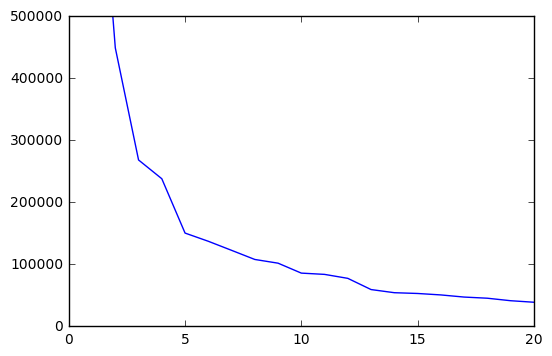

In [10]:
plt.plot(eigenvalues);
plt.xlim([0,20])
plt.ylim([0,500000])

Es ist zu erkennen, dass die Kurve nach 6 Eigenwerten abflacht. Ein weiterer Knick ist beim 14. Eigenwert zu sehen.Also erhalten wir bei der Dimensionsreduktion 6 bzw. 14 Dimensionen. 

In [11]:
_, back_transformed2,_,_ = PCA_transform(images, 14)

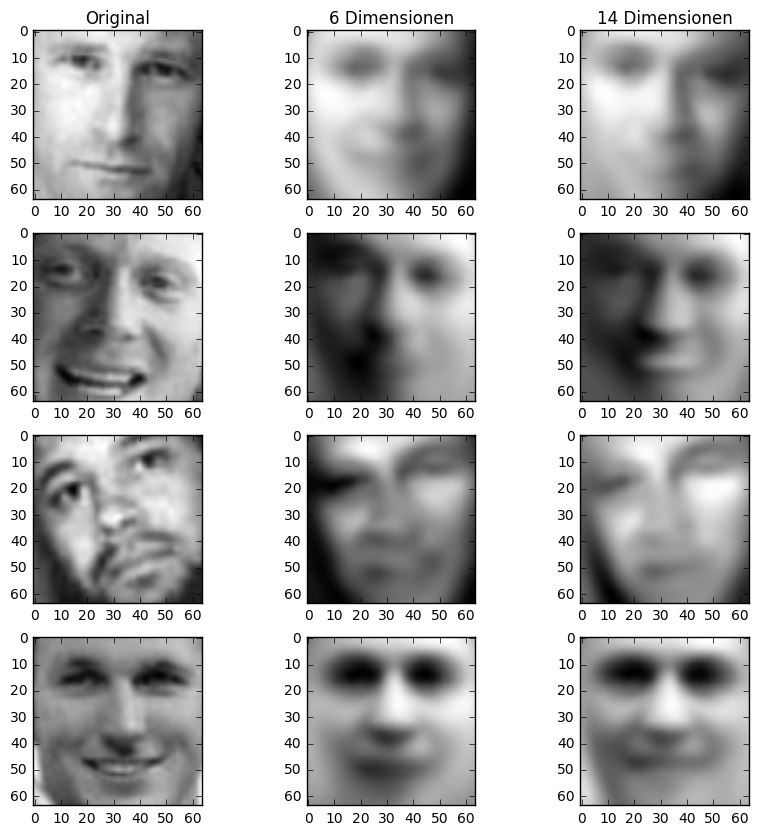

In [12]:
n = 4
fig, ax = plt.subplots(n, 3 ,figsize=(10,10))
for i in range(n):
    ax[i,0].imshow(images[i].reshape((64,64)), cmap = 'gray')
    ax[i,1].imshow(back_transformed[i].reshape((64,64)), cmap = 'gray')
    ax[i,2].imshow(back_transformed2[i].reshape((64,64)), cmap = 'gray')
ax[0,0].set_title('Original')
ax[0,1].set_title('6 Dimensionen')
ax[0,2].set_title('14 Dimensionen');

Zum Schluss visualisieren wir die zu den 20 größten Eigenwerten gehörenden Eigenvektoren:

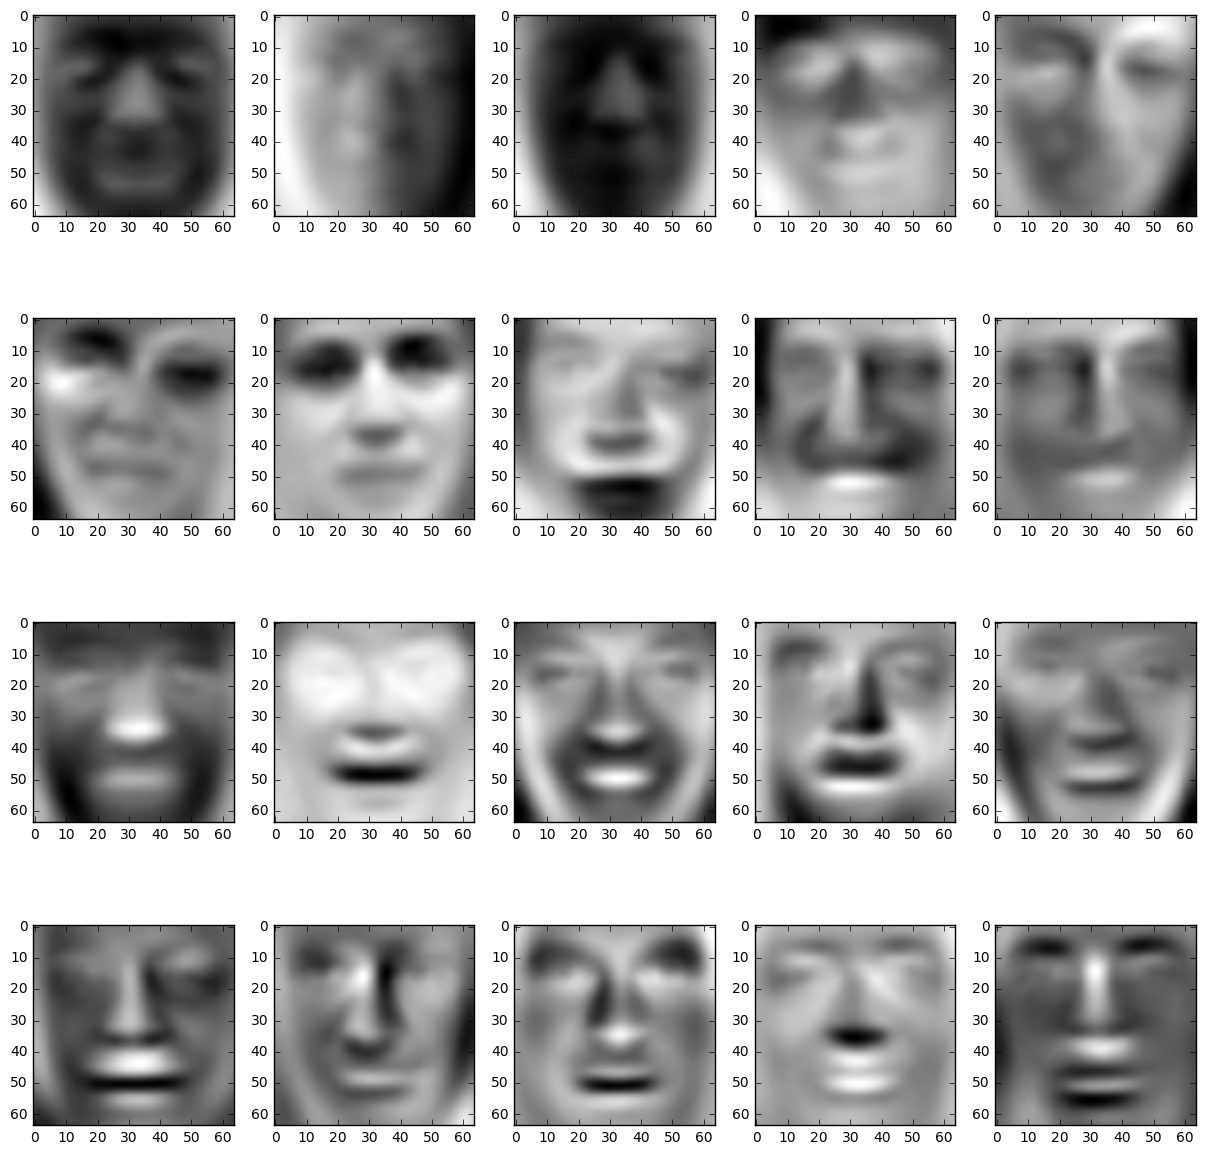

In [13]:
plt.figure(figsize = (15,15))
n = 20
for i,EV in enumerate(eigenvectors[:n]):
    plt.subplot(np.ceil(n/5.),5,1 + i)
    plt.imshow(EV.reshape(64,64), cmap='gray')